# Topic Modeling, Dimensionality Reduction, and K-means Clustering

- This notebook continues from the **Project_04_Classifier_R1** notebook, where the tweets were classified as climate change "believer" or "denier" tweets.
- Before topic modeling is performed, some preliminary steps will be taken
    1. Tweet sentiment will be determined for each tweet. They will be interpreted as either positive, neutral, or negative.
    2. The user location for each tweet will be simplified into two groups: US or Other. Tweets that were created in the US will be focused on for this project.
- In order to produce relevant and informative topics, it was determined that the most important words of each tweet were the nouns. Therefore, each word of each tweet will be tagged with a part of speech and the nouns will be extracted and analyzed.
- Topic modeling will be performed using NMF and TFIDF vectorization.
    - 30 topics will be generated.
- PCA will then be used to perform dimensionality reduction and prepare the topic-document matrix for clustering.
    - A scree plot and cumulative explained variance plot will be used to determine the ideal number of principle components.
- Finally, K-means clustering will be performed.
    - Inertia and silhouette scores will be used to identify the optimum number of clusters, and each tweet will be grouped into a cluster.
    - EDA will be performed to see how tweet sentiment, US regions, and believers vs deniers are distributed throughout each cluster.
    - Further analysis will be done to determine which topics are most prevalent within each cluster.
    

In [369]:
import pickle
import re
import string
import pandas as pd
import numpy as np
from collections import defaultdict
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="whitegrid")
from tqdm.notebook import tqdm

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 60)
pd.set_option('display.precision', 5)

import spacy
import nltk
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
from nltk.stem.lancaster import LancasterStemmer
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')

from textblob import TextBlob
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity

# gensim
import gensim
from gensim import corpora, models, similarities, matutils

# logging for gensim (set to INFO)
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# Load `tweets_classified` from "Project_04_Classifier_R1" notebook

In [2]:
with open('Data/tweets_classified_logit.pkl','rb') as read_file:
    tweets_classified = pickle.load(read_file)

# Document Preprocessing

- Document preprocessing will involve the following steps (and will be executed with various functions):
    - Cleaning (through `tweet_preprocessor`)
        - remove line breaks
        - remove URL's
        - remove numbers
        - remove capital letters and punctuation
    - Lemmatization (through `tweet_tokenizer`)
    - Tokenization (through `tweet_tokenizer`)

In [3]:
def tweet_preprocessor(tweet):

    '''
    Takes in tweet and cleans it by removing line breaks,
    URL's, emojis, numbers, capital letters, and punctuation.
    '''

    tweet = tweet.replace('\n', ' ') # remove line breaks
    tweet = re.sub(r"\bhttps://t.co/\w+", '', tweet) # remove URL's
    tweet = re.sub('\w*\d\w*', ' ', tweet) # remove numbers
    tweet = re.sub('[%s]' % re.escape(string.punctuation), ' ', tweet.lower()) # remove capital letters and punctuation
    
    return tweet

In [4]:
# create a spaCy tokenizer
spacy.load('en')
lemmatizer = spacy.lang.en.English()

def tweet_tokenizer(doc):
    
    '''
    Takes in tweet, tokenizes words, then lemmatizes tokens
    '''
    
    tokens = lemmatizer(doc)
    return [token.lemma_ for token in tokens]

In [5]:
preprocessed_tweet = []

for index, values in tqdm(tweets_classified['full_text'].iteritems()):
    preprocessed = tweet_preprocessor(values)
    tokenized = tweet_tokenizer(preprocessed)
    preprocessed_tweet.append(tokenized)

In [9]:
# Remove spaces from each list

preprocessed_pretweets = []
preprocessed_tweets = []

for tweet in tqdm(preprocessed_tweet):
    for word in tweet:
        if ' ' in word:
            pass
        else:
            preprocessed_pretweets.append(word)
    preprocessed_tweets.append(preprocessed_pretweets)
    preprocessed_pretweets = []

In [14]:
tweets_classified.insert(3, column = 'preprocessed_text', value = preprocessed_tweets)

# Determine sentiment of each tweet using TextBlob

In [19]:
# Convert lists back to strings so that sentiment can be determined

preprocessed_string, preprocessed_strings = '', []

for tweets in tqdm(preprocessed_tweets):
    for word in tweets:
        preprocessed_string += word + ' '
    preprocessed_strings.append(preprocessed_string)
    preprocessed_string = ''

In [16]:
def get_tweet_sentiment(tweet): 
    ''' 
    Utility function to classify sentiment of passed tweet 
    using textblob's sentiment method 
    '''
    # create TextBlob object of passed tweet text 
    analysis = TextBlob(tweet) 
    # set sentiment 
    if analysis.sentiment.polarity > 0: 
        return 'positive'
    elif analysis.sentiment.polarity == 0: 
        return 'neutral'
    else: 
        return 'negative'

In [22]:
tweet_sentiment = [get_tweet_sentiment(tweet) for tweet in tqdm(preprocessed_strings)]

In [23]:
tweets_classified.insert(3, column = 'Tweet_Sentiment', value = tweet_sentiment)

In [24]:
# Quick look at breakdown of tweet sentiment for believers and deniers

tweets_sentiment = tweets_classified.groupby('Believer_or_Denier')['Tweet_Sentiment'].value_counts()
tweets_sentiment

Believer_or_Denier  Tweet_Sentiment
0.0                 positive           1646561
                    neutral            1380910
                    negative            779385
1.0                 positive            156083
                    neutral             138692
                    negative            123785
Name: Tweet_Sentiment, dtype: int64

# Split Tweets by Geographic Location (US vs World)

In [26]:
us_abbrevs = [
              'US', 'USA', 'United States',
              'Alabama','AL','Alaska','AK','Arizona','AZ','Arkansas','AR',
              'California','CA','Colorado','CO','Connecticut','CT',
              'Delaware','DE',
              'Florida','FL',
              'Georgia','GA',
              'Hawaii','HI',
              'Idaho','ID','Illinois','IL','Indiana','IN','Iowa','IA',
              'Kansas','KS','Kentucky','KY',
              'Louisiana','LA',
              'Maine','ME','Maryland','MD','Massachusetts','MA','Michigan','MI',
              'Minnesota','MN','Mississippi','MS','Missouri','MO','Montana','MT',
              'Nebraska','NE','Nevada','NV','New Hampshire','NH','New Jersey','NJ',
              'New Mexico','NM','New York','NY','North Carolina','NC','North Dakota','ND',
              'Ohio','OH','Oklahoma','OK','Oregon','OR',
              'Pennsylvania','PA',
              'Rhode Island','RI',
              'South Carolina','SC','South Dakota','SD',
              'Tennessee','TN','Texas','TX',
              'Utah','UT',
              'Vermont','VT','Virginia','VA',
              'Washington','WA','West Virginia','WV','Wisconsin','WI','Wyoming','WY',
              'District of Columbia','DC'
             ]

In [27]:
# Identify rows that have a US user location, and put them into location_dict

location_dict = {}

for index, rows in tqdm(tweets_classified['User_Location'].iteritems()):
    for loc in us_abbrevs:
        if str(loc) in str(rows):
            location_dict[index] = 'US'
            continue

In [28]:
location_df = pd.DataFrame(list(location_dict.values()), index = list(location_dict.keys()))

In [29]:
tweets_classified['Merge_Index'] = tweets_classified.index
location_df['Merge_Index'] = location_df.index

In [30]:
# Insert updated user location (i.e. US or other) into tweets_classified

tweets_classified_loc = tweets_classified.merge(location_df, how='left', on='Merge_Index')

In [31]:
tweets_classified_loc.rename(columns={0:'US_or_Other'}, inplace=True)

In [32]:
tweets_classified_loc['US_or_Other'] = tweets_classified_loc['US_or_Other'].replace(np.nan,'Other')

In [33]:
tweets_classified_US = tweets_classified_loc[tweets_classified_loc['US_or_Other'] == 'US']

In [34]:
tweets_classified_Other = tweets_classified_loc[tweets_classified_loc['US_or_Other'] == 'Other']

## Save `tweets_classified_US` and `tweets_classified_Other` as pickle files

- These files will be used in the **Project_04_EDA** notebook.

In [35]:
# with open('Data/tweets_classified_US.pkl', 'wb') as to_write:
#     pickle.dump(tweets_classified_US, to_write)

In [36]:
# with open('Data/tweets_classified_Other.pkl', 'wb') as to_write:
#     pickle.dump(tweets_classified_Other, to_write)

---

In [26]:
# with open('tweets_classified_US_2017.pkl','rb') as read_file:
#     tweets_classified_US_2017 = pickle.load(read_file)

# with open('tweets_classified_US_2018.pkl','rb') as read_file:
#     tweets_classified_US_2018 = pickle.load(read_file)

# with open('tweets_classified_US_2019.pkl','rb') as read_file:
#     tweets_classified_US_2019 = pickle.load(read_file)

---

# Part of Speech Tagging

- To determine the topic of each tweet, it makes sense to focus on the nouns. Nouns will be extracted from each tweet and used for topic modeling.
    

In [48]:
def get_nouns(tweet_df):

    tweet_series = tweet_df['preprocessed_text']
        
    pos_list, pos_prelist = [], []
    
    for index, tweet in tqdm(tweet_series.iteritems()):
        pos_pair = pos_tag(tweet)
        pos_prelist.append(pos_pair)
    pos_list.append(pos_prelist)
    pos_prelist = []

    nouns_list, nouns_prelist = [], []

    for second_bracket in tqdm(pos_list):
        for tweet in second_bracket:
            for word in tweet:
                if word[1] == 'NN':
                    nouns_prelist.append(word[0])
                elif word[1] == 'NNS':
                    nouns_prelist.append(word[0])
                elif word[1] == 'NNP':
                    nouns_prelist.append(word[0])
                elif word[1] == 'NNPS':
                    nouns_prelist.append(word[0])
            nouns_list.append(nouns_prelist)
            nouns_prelist = []

    noun_tweet, noun_tweets = '', []

    for tweets in tqdm(nouns_list):
        for noun in tweets:
            noun_tweet += noun + ' '
        noun_tweets.append(noun_tweet)
        noun_tweet = ''
        
    return tweet_series, pos_list, nouns_list, noun_tweets

In [49]:
tweet_series, pos_list, nouns_list, noun_tweets = get_nouns(tweets_classified_US)

In [50]:
len(nouns_list)

1235350

In [51]:
# noun_tweets17 = get_nouns(tweets_classified_US_2017)
# noun_tweets18 = get_nouns(tweets_classified_US_2018)
# noun_tweets19 = get_nouns(tweets_classified_US_2019)

# Topic Modeling
- NMF will be used to determine top 30 topics from the tweets
- TFIDF vectorization will be used with the following parameters:
    - ngrams of length 2 or 3
    - words/phrases must show up at least 3 times
    - words/phrases cannot show up in more than 95% of the tweets
    - stop words include standard English stop words and phrases such as "climate change" and "global warming"

In [88]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [58]:
def NMF_model(tweet_df, tweets_list, no_topics):
    
    add_stop_words = ['climate change', 'climate', 'global warming', 'amp', 'climatechange', 'global', 'warming', 
                      'globalwarming', 'just', 'climateaction', 'change', 'really', 'eco', 'stevennbeck', 'boomerscomics', 'comics']
    new_stop_words = text.ENGLISH_STOP_WORDS.union(add_stop_words)
    
    vectorizer = TfidfVectorizer(ngram_range = (2,3), max_df = 0.95, min_df = 3, stop_words=new_stop_words)
    doc_word_nmf = vectorizer.fit_transform(tweets_list)
    nmf_model = NMF(no_topics)
    doc_topic_nmf = nmf_model.fit_transform(doc_word_nmf)
    
    topics_list = display_topics(nmf_model, vectorizer.get_feature_names(), 10)
    
    columns = ['Topic_' + str(i) for i in range(no_topics)]
    H = pd.DataFrame(doc_topic_nmf.round(5), index = tweet_df.index, columns = columns)
    H.insert(0, column = 'full_text', value = tweet_df['full_text']) 
    
    return topics_list, H

In [78]:
topics, H = NMF_model(tweets_classified_US, noun_tweets, 30)



Topic  0
report humans, humans trump, trump officials, humans trump officials, report humans trump, officials nytimes, trump officials nytimes, government report humans, trump officials york, officials york

Topic  1
trumptrain maga, trumplies trumptrain, trumplies trumptrain maga, goptaxscam jobs, trumptrain maga goptaxscam, maga goptaxscam, maga goptaxscam jobs, impeachtrump trumplies, impeachtrump trumplies trumptrain, votethemout trumplies

Topic  2
tax cut, trump tax, trump tax cut, company trump, company trump tax, ceo company, ceo company trump, patagonia ceo, patagonia ceo company, dollar company trump

Topic  3
banks rights, sign banks, sign banks rights, rights actcampaign, banks rights actcampaign, banks rights equatorbanksact, rights equatorbanksact, equatorbanksact actcampaign, rights equatorbanksact actcampaign, tell banks rights

Topic  4
administration explanation, trump administration explanation, explanation wapo, administration explanation wapo, administration expla

In [99]:
# Replace the column names in H with the following topic titles (determined from the topics above)

topics_cleaned = ['full_text', 'Contradict Trump', 'Donald Trump Lies (Impeachment)', 'Patagonia CEO Donation',
                  'Equator Banks Act', 'Nov 2017 Scientific Report (Wash_Post)', 'Air and Water Quality',
                  'Sea Levels Rise', 'Animals at Risk', 'EPA Cancels CC Scientist Talks (NY_Times)',
                  'Al Gore', 'Obama Era Policies', 'Women Involvement', 'BlackRock_Petition',
                  'Animal Protection', 'Mini Ice Age', 'Human Impact on Earth', 'Coal Conference',  
                  'Oil Company Lawsuit', 'Cost of Climate Change', 'Scott Pruitt', 'Activism',                   
                  'Teach Climate Change', 'CO2 Emissions', 'Energy Innovation (Carbon Dividend)', 
                  'Auto Alliance', 'EPA Yanks CC Conference (Wash_Post)', 'Paris Agreement', 
                  'Greenhouse Gas Emissions', 'Ralph B Alexander', 'Earth Day']

---

In [156]:
# topics_2019 = ['BlackRock_Petition', 'Teach Climate Change', 'Activism',
#                'Ralph B. Alexander', 'Earth Day', 'Liberal Politicians',
#                'Oil Industry Policies', 'CO2 Levels', 'Trump Admin Policies',
#                'NYC Hot Dog Ban', 'NYC Hot Dog Ban', 'Power Pros Cons',
#                'Congress Climate Priority', 'Sea Level Rise', 'NZ Planting Trees']

In [161]:
# topics_2017, H_17 = NMF_model(tweets_classified_US_2017, noun_tweets17, 15)

In [157]:
# topics_2018 = ['Donald Trump Lies', 'Clean Air and Water', 'Patagonia CEO Donation',
#                'Animals at Risk', 'Women Involvement', 'Al Gore',
#                'Sea Level Rise', 'EPA Scott Pruitt', 'Auto Alliance',
#                'Oil Company Lawsuit', 'Paris Agreement', 'Boomers Comics',
#                'Ice Age', 'Protect Animals', 'Energy Innovation (Carbon Dividend)']

In [162]:
# topics_2018, H_18 = NMF_model(tweets_classified_US_2018, noun_tweets18, 15)

In [158]:
# topics_2017 = ['Contradict Trump', 'Equator Banks Act', 'Nov 2017 Scientific Report (Wash_Post)',
#                'EPA Cancels CC Scientist Talks (Huff_Post)', 'Obama Power Plan', 'Costs of Climate Change',
#                'EPA Cancels CC Scientist Talks (Wash_Post)', 'Nov 2017 Scientific Report', 'Climate Change Taxpayer Cost', 'Trump Admin Policies (NYTimes)',
#                'Greenhouse Gas Emissions', 'Trump Skepticism', 'Nov 2017 Scientific Report (Wash_Post_#2)',
#                'Congress Climate Priority', 'Climate Change Taxpayer Cost (NBC News)', 'Hurricanes']


In [163]:
# topics_2019, H_19 = NMF_model(tweets_classified_US_2019, noun_tweets19, 15)

---

## Clean up `H` dataframe
- Rename column names with topic titles
- Add in the following features
    - Believer_or_Denier
    - Tweet_Sentiment (get dummies)
    - User_Region (get dummies)

In [81]:
H.columns = topics_cleaned

In [83]:
H.insert(1, column = 'Believer_or_Denier', value = tweets_classified_US['Believer_or_Denier'])

In [84]:
H.insert(2, column = 'Tweet_Sentiment', value = tweets_classified_US['Tweet_Sentiment'])

In [68]:
with open('Data/tweets_classified_US_region.pkl','rb') as read_file:
    tweets_classified_US_region = pickle.load(read_file)

In [85]:
H.insert(3, column = 'User_Region', value = tweets_classified_US_region['User_Region']

In [86]:
H = pd.get_dummies(H, prefix = ['User_Region'], columns = ['User_Region'])
H = pd.get_dummies(H, prefix = ['Tweet_Sentiment'], columns = ['Tweet_Sentiment'])

In [134]:
H

,full_text,User_Name,Believer_or_Denier,Contradict Trump,Donald Trump Lies (Impeachment),Patagonia CEO Donation,Equator Banks Act,Nov 2017 Scientific Report (Wash_Post),Air and Water Quality,Sea Levels Rise,Animals at Risk,EPA Cancels CC Scientist Talks (NY_Times),Al Gore,Obama Era Policies,Women Involvement,BlackRock_Petition,Animal Protection,Mini Ice Age,Human Impact on Earth,Coal Conference,Oil Company Lawsuit,Cost of Climate Change,Scott Pruitt,Activism,Teach Climate Change,CO2 Emissions,Energy Innovation (Carbon Dividend),Auto Alliance,EPA Yanks CC Conference (Wash_Post),Paris Agreement,Greenhouse Gas Emissions,Ralph B Alexander,Earth Day,User_Region_Alaska,User_Region_Hawaii,User_Region_Midwest,User_Region_Northeast,User_Region_Rockies,User_Region_South,User_Region_Southwest,User_Region_US,User_Region_West Coast,Tweet_Sentiment_negative,Tweet_Sentiment_neutral,Tweet_Sentiment_positive
0,"All #Hurricane victims should sue #Trump, #Pru...",Soledad Haren,0.00000,0.00000,0.00003,0.00000,0.00000,0.00000,0.00000,0.00003,0.00000,0.00002,0.00000,0.00001,0.00000,0.00000,0.00000,0.00000,0.00002,0.00001,0.00204,0.00000,0.00002,0.00000,0.00000,0.00002,0.00000,0.00000,0.00000,0.00000,0.00001,0.00000,0.00000,0,0,0,1,0,0,0,0,0,0,1,0
3,San Francisco sues oil companies over #climate...,A&R Solar,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00004,0.00000,0.00000,0.00000,0.10203,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0,0,0,0,0,0,0,0,1,0,1,0
6,Is the 2017 #hurricane season worse than usual...,YouthBuild USA Green,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00002,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00008,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00001,0,0,0,1,0,0,0,0,0,1,0,0
9,Trudeau is transitioning to climate change dis...,brad schaible,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0,0,0,0,0,1,0,0,0,0,0,1
17,These Vermont-based companies want to conquer ...,Seven Days,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00001,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00008,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0,0,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4225408,The latest YHWH HOLY SCRIPTURES! https://t.co/...,CarrieGaard,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0,0,0,0,0,1,0,0,0,0,0,1
4225409,All 800 left. https://t.co/Dr5aROHJzb,Simarilian,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0,0,0,0,0,0,0,0,1,0,1,0
4225410,"Look at this clever animation, showing the tem...",Claudio Alatorre,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0,0,0,1,0,0,0,0,0,0,0,1
4225411,Climate Change: Why The Australian Labor Party...,Iowa Climate ����,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.

In [89]:
# with open('Data/cluster_df.pkl', 'wb') as to_write:
#     pickle.dump(H, to_write)

In [93]:
with open('Data/cluster_df.pkl','rb') as read_file:
    cluster_df = pickle.load(read_file)

In [94]:
del cluster_df['full_text']

# PCA

- Dimensionality reduction will be performed with PCA
- A scree plot will be used to determine the ideal number of components
    - The following question needs to be answered:
        - How many components are needed to explain at least 80% of the variance of the dataset?

In [105]:
from sklearn import datasets
from sklearn.decomposition import PCA

In [236]:
std = StandardScaler()

std.fit(cluster_df.values)
cluster_scaled = std.transform(cluster_df.values)

In [97]:
cluster_array = cluster_df.to_numpy()

In [211]:
def pca_function(array, n_components, random_state):
    
    pca = PCA(n_components=n_components, random_state=random_state)
    pca.fit(array)
    pca_features = pca.transform(array)
    
    return pca, pca_features

In [259]:
pca40, pca40_features = pca_function(cluster_scaled, 40, 42)

## Scree Plot and Cumulative Explained Variance Plot

- It's important to explain at least 80% of the variance. This occurs at around 30 principal components.
- Moving past 30, there is a noticeable elbow at 39 components.
- It appears that the variance is almost completely explained at this point, so 39 components will be used.

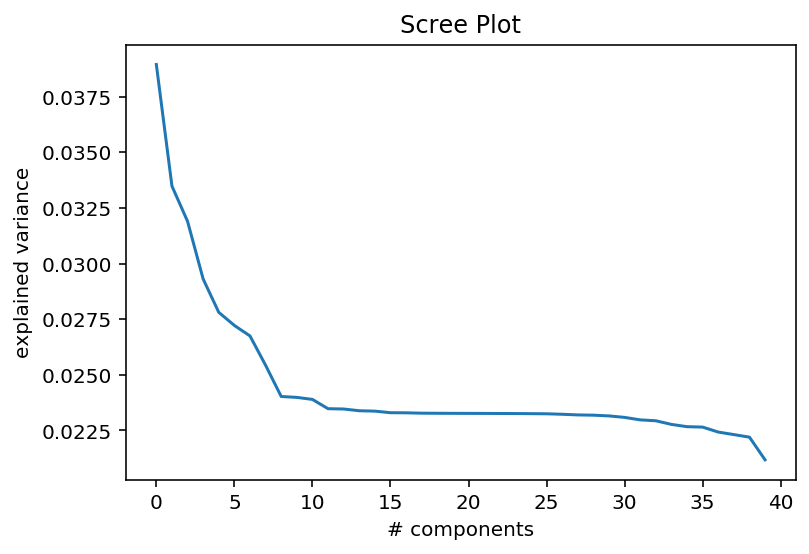

In [260]:
plt.plot(pca40.explained_variance_ratio_)
plt.xlabel('# components')
plt.ylabel('explained variance');
plt.title('Scree Plot');

Text(0.5, 1.0, 'Cumulative explained variance by PCA')

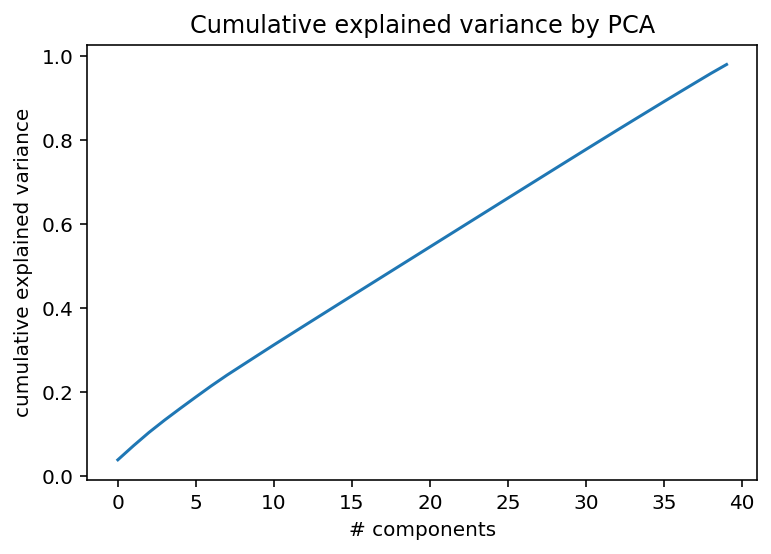

In [261]:
plt.plot(np.cumsum(pca40.explained_variance_ratio_))
plt.xlabel('# components')
plt.ylabel('cumulative explained variance');
plt.title('Cumulative explained variance by PCA')

## Create `pca_df`

In [262]:
pca39, pca39_features = pca_function(cluster_array, 39, 42)

In [265]:
pca_index = ['PC' + str(i) for i in range(1,40)]

In [266]:
pca_df = pd.DataFrame(pca39.components_, columns = cluster_df.columns, index = pca_index)

In [267]:
pd.options.display.float_format = '{:.5f}'.format

In [268]:
pca_df

,Believer_or_Denier,Contradict Trump,Donald Trump Lies (Impeachment),Patagonia CEO Donation,Equator Banks Act,Nov 2017 Scientific Report (Wash_Post),Air and Water Quality,Sea Levels Rise,Animals at Risk,EPA Cancels CC Scientist Talks (NY_Times),Al Gore,Obama Era Policies,Women Involvement,BlackRock_Petition,Animal Protection,Mini Ice Age,Human Impact on Earth,Coal Conference,Oil Company Lawsuit,Cost of Climate Change,Scott Pruitt,Activism,Teach Climate Change,CO2 Emissions,Energy Innovation (Carbon Dividend),Auto Alliance,EPA Yanks CC Conference (Wash_Post),Paris Agreement,Greenhouse Gas Emissions,Ralph B Alexander,Earth Day,User_Region_Alaska,User_Region_Hawaii,User_Region_Midwest,User_Region_Northeast,User_Region_Rockies,User_Region_South,User_Region_Southwest,User_Region_US,User_Region_West Coast,Tweet_Sentiment_negative,Tweet_Sentiment_neutral,Tweet_Sentiment_positive
PC1,0.01521,-0.00022,0.00004,0.00018,0.00022,0.00004,-0.00019,-0.00000,0.00003,0.00017,0.00006,-0.00016,0.00002,0.00015,-0.00015,-0.00002,0.00011,0.00000,-0.00008,0.00003,0.00004,-0.00017,-0.00013,0.00011,-0.00002,0.00013,0.00009,0.00011,-0.00005,0.00014,0.00006,-0.00027,0.00048,0.00534,-0.04021,0.00280,0.02606,0.00059,0.01192,-0.00672,0.07515,0.66555,-0.74070
PC2,0.09679,-0.00006,-0.00043,-0.00007,-0.00007,0.00016,0.00006,-0.00002,-0.00011,-0.00007,0.00012,0.00007,0.00002,-0.00006,-0.00010,0.00013,-0.00005,-0.00003,-0.00001,0.00011,0.00006,0.00012,-0.00002,0.00001,-0.00000,-0.00002,-0.00001,-0.00005,-0.00006,-0.00000,-0.00003,0.00144,0.00148,0.10433,-0.79248,0.02593,0.28547,0.01111,0.08466,0.27805,0.34503,-0.22901,-0.11602
PC3,0.03527,-0.00010,0.00016,-0.00014,-0.00015,0.00037,-0.00013,0.00003,0.00047,-0.00004,-0.00001,-0.00011,0.00033,-0.00010,-0.00003,0.00001,-0.00009,-0.00003,-0.00003,0.00024,0.00015,-0.00016,-0.00006,-0.00008,-0.00009,-0.00010,-0.00005,-0.00005,0.00000,-0.00011,-0.00004,-0.00069,-0.00194,-0.04373,0.37909,-0.01457,-0.11144,-0.00524,-0.02787,-0.17361,0.73267,-0.41294,-0.31973
PC4,0.08974,-0.00002,-0.00001,-0.00004,-0.00005,-0.00004,0.00002,-0.00000,-0.00004,-0.00003,0.00018,0.00026,-0.00003,-0.00000,0.00009,0.00013,0.00001,-0.00002,-0.00000,-0.00003,-0.00003,-0.00035,0.00002,-0.00000,-0.00004,-0.00003,-0.00001,0.00000,-0.00005,0.00000,0.00002,0.00013,0.00015,0.01338,-0.01136,0.00229,0.69286,0.00116,0.01439,-0.71299,-0.04162,0.00643,0.03520
PC5,0.07517,-0.00003,-0.00011,-0.00003,-0.00003,-0.00002,0.00035,-0.00010,-0.00008,-0.00003,0.00009,-0.00017,-0.00004,-0.00000,-0.00005,0.00007,-0.00001,0.00001,0.00001,-0.00003,-0.00001,-0.00021,0.00000,0.00009,0.00001,-0.00000,-0.00000,-0.00000,-0.00000,0.00039,-0.00003,0.00240,0.00334,0.67735,-0.19031,0.05595,-0.46667,0.02024,0.31790,-0.42020,-0.01493,0.00366,0.01127
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PC35,0.00011,0.00156,0.00173,0.00049,0.00029,0.00611,0.00103,0.00332,0.00674,0.00179,-0.00022,-0.00070,0.01030,0.00069,0.00081,0.00347,-0.03557,0.00680,0.00402,0.99883,-0.02514,0.00216,0.00139,-0.00784,-0.00771,0.00103,-0.00164,-0.00220,-0.00457,-0.00008,0.00160,0.00003,0.00003,0.00002,-0.00001,-0.00002,-0.00000,-0.00001,-0.00002,-0.00001,-0.00023,0.00012,0.00011
PC36,0.00011,0.00232,0.00198,0.00240,0.00229,0.00077,0.00205,0.00360,0.00040,0.00309,0.00142,0.00517,0.00120,0.00393,0.00375,0.00324,0.01660,0.00532,0.00847,0.00685,-0.03643,0.01091,0.00682,-0.04015,0.99813,0.00556,-0.00303,-0.00391,-0.00499,0.00301,0.00179,0.00009,0.00005,-0.00009,0.00001,-0.00007,-0.00002,0.00005,0.00005,-0.00007,0.00007,-0.00002,-0.00005
PC37,0.00006,0.00150,0.00279,0.00219,0.00200,0.00433,0.00241,0.00439,0.00553,0.00008,0.00381,-0.01559,0.00746,0.00224,0.00270,0.00625,0.00355,-0.00170,0.00808,0.02389,0.98735,0.00545,0.00353,-0.13536,0.03027,0.00377,-0.00302,0.06200,-0.02951,0.00195,0.00232,0.00004,-0.00009,-0.00003,-0.00004,0.00023,-0.00002,0.00000,-0.00004,-0.00005,-0.00015,0.00006,0.0

# K-Means Clustering

- The ultimate goal for this project is to identify sentiment trends across US regions.
- How do believers and deniers feel about the topics identified in our topic modeling? Does it vary by region?
- K-means will be used to cluster the data and determine any relevant sentiment trends

In [136]:
# uses custom metis style sheet for notebooks
# from IPython.core.display import HTML
# HTML("""<link rel="stylesheet" href="https://soph.info/metis/nb.css" type="text/css"/>""")

# import sklearn
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.metrics import silhouette_score

## Inertia and Silhouette Score

- Inertia (sum of squared error) and the silhouette score (cluster cohesiveness and separation) will be used to determine the ideal number of clusters
- There is a spike in the silhouette score at k=5 clusters, so 5 clusters will be used

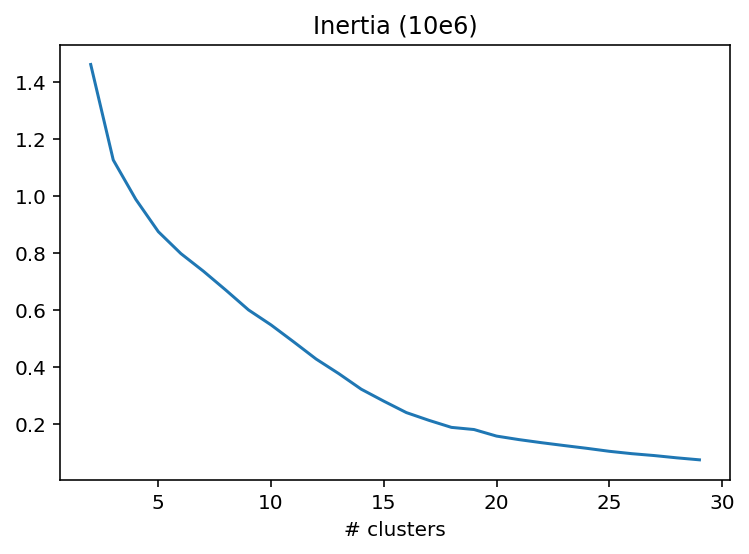

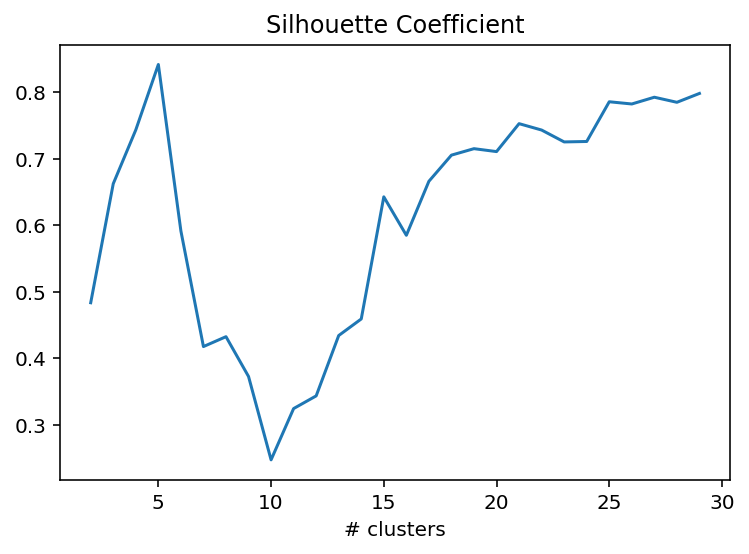

In [269]:
inertia = []
sil_coefs = []

for k in tqdm(range(2,30)):
    km = KMeans(n_clusters=k, n_init=15, random_state=42)
    km.fit(pca39_features)
    
    inertia.append(km.inertia_)
    
    labels = km.labels_
    sil_coefs.append(metrics.silhouette_score(pca_features, labels, metric='euclidean', random_state=42, sample_size=50000))

plt.plot(range(2,30), [i/1000000 for i in inertia])
plt.xlabel('# clusters')
plt.title('Inertia (10e6)')
plt.show()
plt.plot(range(2,30), sil_coefs)
plt.xlabel('# clusters')
plt.title('Silhouette Coefficient')
plt.show()

## Cluster Prediction

In [288]:
# Compute the clusters
km5 = KMeans(n_clusters=5, random_state=42, n_init=15)
clusters_pca = km5.fit_predict(pca39_features)

In [289]:
pca_pred_dict = {}

for i in range(1,40):
    pca_pred_dict['PC' + str(i)] = pca39_features[:,i-1]
    if i == 39:
        pca_pred_dict['k_means_predict'] = clusters_pca

In [290]:
pca_pred_df = pd.DataFrame(pca_pred_dict)

In [291]:
pca_pred_df.k_means_predict.value_counts()

1    356248
0    309684
2    268478
4    166852
3    134088
Name: k_means_predict, dtype: int64

### Cluster EDA

- The following questions will be answered in this section:
    - How are tweet sentiments distributed throughout US regions? (i.e. are certain regions more positive, negative, etc.?)
        - **Answer**: Although the ratios aren't exactly the same, each region has mostly positive tweets, fewer neutral tweets, and even fewer negative tweets
    - How are believers and deniers represented in each cluster?
        - **Answer**:
            - Cluster 0: close to average ratio of deniers to believers
            - Cluster 1: close to average ratio of deniers to believers
            - Cluster 2: higher than average ratio of deniers to believers
            - Cluster 3: lower than average ratio of deniers to believers
            - Cluster 4: lower than average ratio of deniers to believers
    - How are regions represented in each cluster?
        - **Answer**:
            - Cluster 0: All regions except Northeast, slightly more South than average
            - Cluster 1: All regions except Northeast, slightly more West than average
            - Cluster 2: All regions
            - Cluster 3: Northeast only
            - Cluster 4: Northeast only
    - How is tweet sentiment represented in each cluster?
        - **Answer**:
            - Cluster 0: neutral
            - Cluster 1: positive
            - Cluster 2: negative
            - Cluster 3: neutral
            - Cluster 4: positive

In [322]:
kmeans_df = tweets_classified_US_region[['Believer_or_Denier', 'Tweet_Sentiment', 'User_Region']].reset_index(drop=True)

In [323]:
kmeans_df['Cluster'] = clusters_pca

In [324]:
kmeans_df = kmeans_df.reset_index()

#### Tweets by cluster, believer vs denier, region, and sentiment

In [350]:
kmeans_cluster_df = kmeans_df.groupby(['Cluster', 'Believer_or_Denier', 'Tweet_Sentiment', 'User_Region']).agg({'index':'count'}).reset_index().sort_values(by=['Cluster', 'Believer_or_Denier', 'Tweet_Sentiment', 'User_Region'])
kmeans_cluster_df

,Cluster,Believer_or_Denier,Tweet_Sentiment,User_Region,index
0,0,0.00000,neutral,Alaska,1227
1,0,0.00000,neutral,Hawaii,2161
2,0,0.00000,neutral,Midwest,48746
3,0,0.00000,neutral,Rockies,20840
4,0,0.00000,neutral,South,72169
5,0,0.00000,neutral,Southwest,9090
6,0,0.00000,neutral,US,40789
7,0,0.00000,neutral,West Coast,74748
8,0,1.00000,neutral,Alaska,128
9,0,1.00000,neutral,Hawaii,169


In [352]:
# Tweet Sentiment by Region

kmeans_reg_sent_df = kmeans_df.groupby(['User_Region', 'Tweet_Sentiment']).agg({'index':'count'}).reset_index()
kmeans_reg_sent_df.head(10)

,User_Region,Tweet_Sentiment,index
0,Alaska,negative,878
1,Alaska,neutral,1355
2,Alaska,positive,1836
3,Hawaii,negative,991
4,Hawaii,neutral,2330
5,Hawaii,positive,2379
6,Midwest,negative,34882
7,Midwest,neutral,55475
8,Midwest,positive,64616
9,Northeast,negative,77550


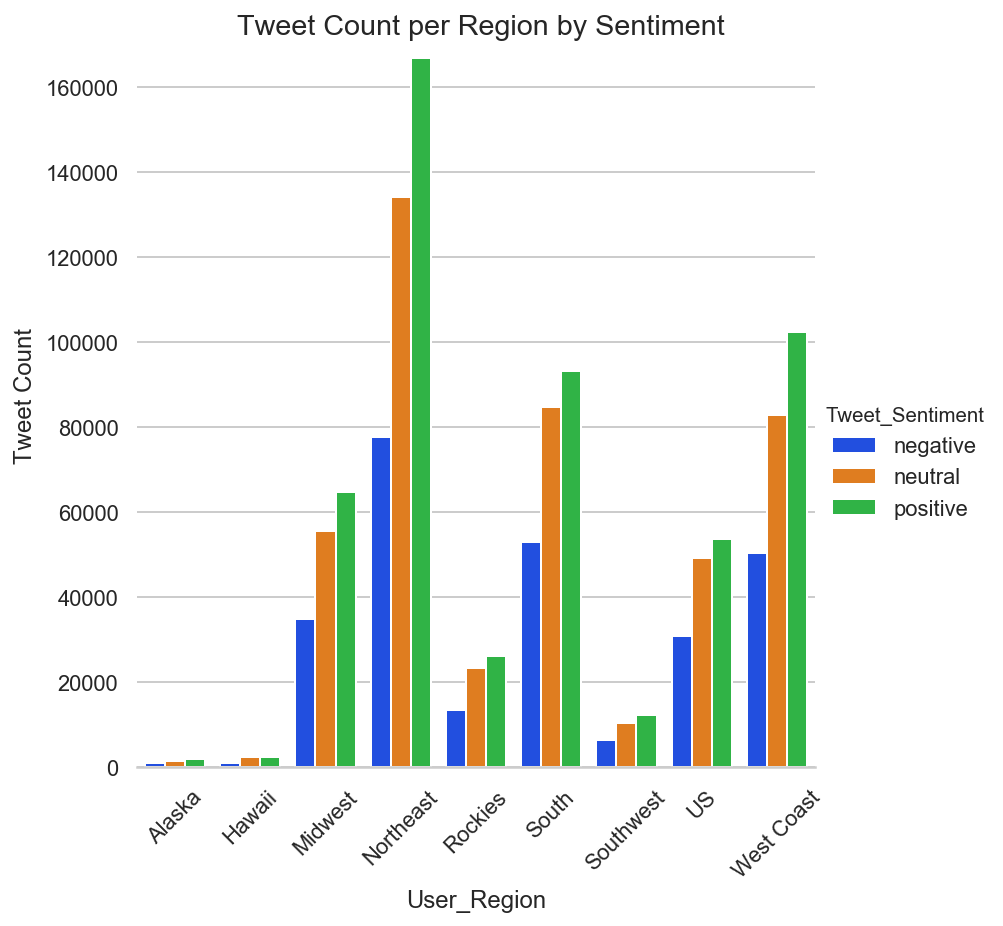

In [362]:
# Tweet count per region by sentiment

reg_sent_barplot = sns.catplot(x="User_Region", y="index", hue="Tweet_Sentiment", data=kmeans_reg_sent_df,
                height=6, kind="bar", palette="bright")
reg_sent_barplot.despine(left=True)
reg_sent_barplot.fig.suptitle("Tweet Count per Region by Sentiment")
reg_sent_barplot.set_xticklabels(rotation=45)
reg_sent_barplot.set_ylabels("Tweet Count")

>Although the ratios aren't exactly the same, each region has mostly positive tweets, fewer neutral tweets, and even fewer negative tweets

#### Believer vs Denier Count by Cluster

In [330]:
print(kmeans_df.groupby(['Cluster', 'Believer_or_Denier'])['Believer_or_Denier'].count())
print(' ')
print('Cluster 0 % Denier Tweets:', round(100*39914/(269770+39914), 1), '%')
print('Cluster 1 % Denier Tweets:', round(100*43536/(312712+43536), 1), '%')
print('Cluster 2 % Denier Tweets:', round(100*43932/(224546+43932), 1), '%')
print('Cluster 3 % Denier Tweets:', round(100*10487/(123601+10487), 1), '%')
print('Cluster 4 % Denier Tweets:', round(100*12068/(154784+12068), 1), '%')

Cluster  Believer_or_Denier
0        0.00000               269770
         1.00000                39914
1        0.00000               312712
         1.00000                43536
2        0.00000               224546
         1.00000                43932
3        0.00000               123601
         1.00000                10487
4        0.00000               154784
         1.00000                12068
Name: Believer_or_Denier, dtype: int64
 
Cluster 0 % Denier Tweets: 12.9 %
Cluster 1 % Denier Tweets: 12.2 %
Cluster 2 % Denier Tweets: 16.4 %
Cluster 3 % Denier Tweets: 7.8 %
Cluster 4 % Denier Tweets: 7.2 %


>Cluster 0: close to average ratio of deniers to believers  
>Cluster 1: close to average ratio of deniers to believers  
>Cluster 2: higher than average ratio of deniers to believers  
>Cluster 3: lower than average ratio of deniers to believers  
>Cluster 4: lower than average ratio of deniers to believers 

#### Users per cluster by region

In [338]:
kmeans_region_df = kmeans_df.groupby(['Cluster', 'User_Region']).agg({'index':'count'}).reset_index()
kmeans_region_df.head(10)


,Cluster,User_Region,index
0,0,Alaska,1355
1,0,Hawaii,2330
2,0,Midwest,55475
3,0,Rockies,23304
4,0,South,84748
5,0,Southwest,10455
6,0,US,49181
7,0,West Coast,82836
8,1,Alaska,1836
9,1,Hawaii,2379


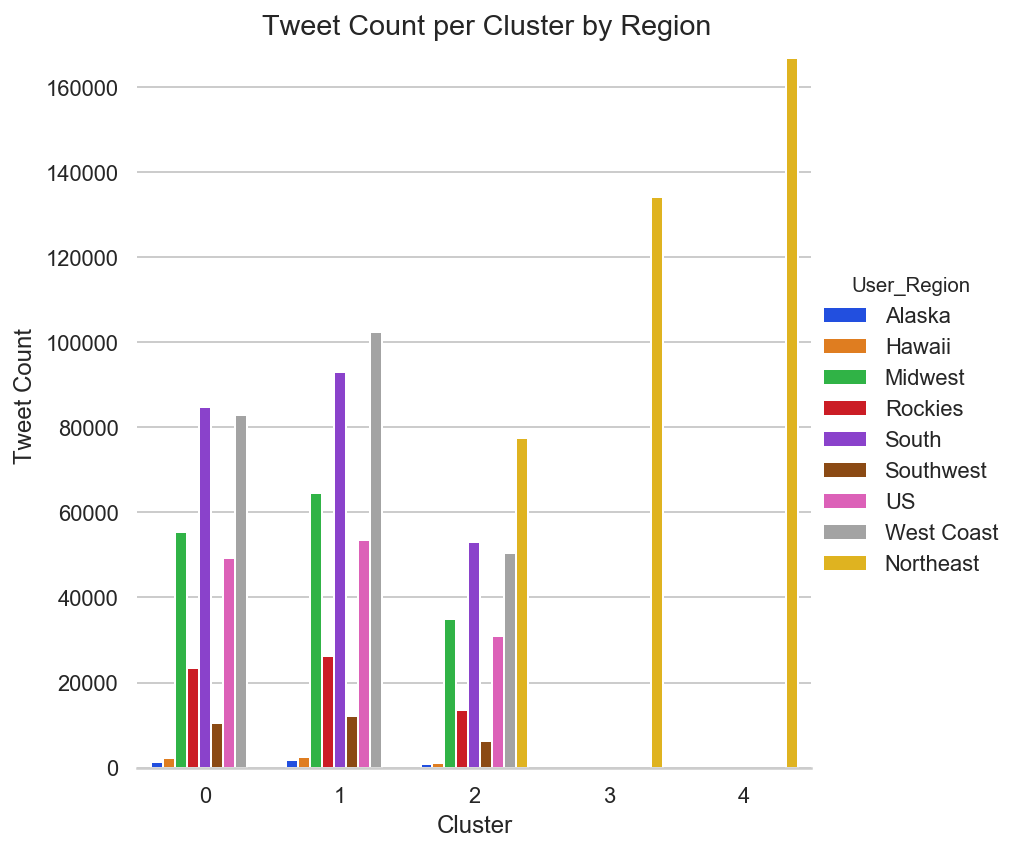

In [363]:
region_barplot = sns.catplot(x="Cluster", y="index", hue="User_Region", data=kmeans_region_df,
                height=6, kind="bar", palette="bright")
region_barplot.despine(left=True)
region_barplot.fig.suptitle("Tweet Count per Cluster by Region")
region_barplot.set_ylabels("Tweet Count")


>Cluster 0: All regions except Northeast, slightly more South than average  
>Cluster 1: All regions except Northeast, slightly more West than average  
>Cluster 2: All regions  
>Cluster 3: Northeast only  
>Cluster 4: Northeast only

#### Tweet Sentiment per Cluster

In [335]:
kmeans_df.groupby(['Cluster', 'Tweet_Sentiment'])['Tweet_Sentiment'].count()


Cluster  Tweet_Sentiment
0        neutral            309684
1        positive           356248
2        negative           268478
3        neutral            134088
4        positive           166852
Name: Tweet_Sentiment, dtype: int64

>Cluster 0: neutral  
>Cluster 1: positive  
>Cluster 2: negative  
>Cluster 3: neutral  
>Cluster 4: positive  

## Topic Prevalence in Each Cluster

In [365]:
# Add cluster prediction column to cluster_df

cluster_df2 = cluster_df.copy()
cluster_df2 = cluster_df2.reset_index(drop=True)
cluster_df2['Cluster'] = clusters_pca
cluster_df2

,Believer_or_Denier,Contradict Trump,Donald Trump Lies (Impeachment),Patagonia CEO Donation,Equator Banks Act,Nov 2017 Scientific Report (Wash_Post),Air and Water Quality,Sea Levels Rise,Animals at Risk,EPA Cancels CC Scientist Talks (NY_Times),Al Gore,Obama Era Policies,Women Involvement,BlackRock_Petition,Animal Protection,Mini Ice Age,Human Impact on Earth,Coal Conference,Oil Company Lawsuit,Cost of Climate Change,Scott Pruitt,Activism,Teach Climate Change,CO2 Emissions,Energy Innovation (Carbon Dividend),Auto Alliance,EPA Yanks CC Conference (Wash_Post),Paris Agreement,Greenhouse Gas Emissions,Ralph B Alexander,Earth Day,User_Region_Alaska,User_Region_Hawaii,User_Region_Midwest,User_Region_Northeast,User_Region_Rockies,User_Region_South,User_Region_Southwest,User_Region_US,User_Region_West Coast,Tweet_Sentiment_negative,Tweet_Sentiment_neutral,Tweet_Sentiment_positive,Cluster
0,0.00000,0.00000,0.00003,0.00000,0.00000,0.00000,0.00000,0.00003,0.00000,0.00002,0.00000,0.00001,0.00000,0.00000,0.00000,0.00000,0.00002,0.00001,0.00204,0.00000,0.00002,0.00000,0.00000,0.00002,0.00000,0.00000,0.00000,0.00000,0.00001,0.00000,0.00000,0,0,0,1,0,0,0,0,0,0,1,0,3
1,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00004,0.00000,0.00000,0.00000,0.10203,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0,0,0,0,0,0,0,0,1,0,1,0,0
2,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00002,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00008,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00001,0,0,0,1,0,0,0,0,0,1,0,0,2
3,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0,0,0,0,0,1,0,0,0,0,0,1,1
4,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00001,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00008,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0,0,0,1,0,0,0,0,0,0,1,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1235345,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0,0,0,0,0,1,0,0,0,0,0,1,1
1235346,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0,0,0,0,0,0,0,0,1,0,1,0,0
1235347,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0,0,0,1,0,0,0,0,0,0,0,1,4
1235348,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00001,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00004,0,0,1,0,0,0,0,0,0,0,0,1,1


In [393]:
# Determine how prevelant each topic is within each cluster

cluster_topic_df = cluster_df2.groupby('Cluster').agg({'Contradict Trump': 'sum',
                                                       'Donald Trump Lies (Impeachment)': 'sum',
                                                       'Patagonia CEO Donation': 'sum',
                                                       'Equator Banks Act': 'sum',
                                                       'Nov 2017 Scientific Report (Wash_Post)': 'sum',
                                                       'Air and Water Quality': 'sum',
                                                       'Sea Levels Rise': 'sum',
                                                       'Animals at Risk': 'sum',
                                                       'EPA Cancels CC Scientist Talks (NY_Times)': 'sum',
                                                       'Al Gore': 'sum',
                                                       'Obama Era Policies': 'sum',
                                                       'Women Involvement': 'sum',
                                                       'BlackRock_Petition': 'sum',
                                                       'Animal Protection': 'sum',
                                                       'Mini Ice Age': 'sum',
                                                       'Human Impact on Earth': 'sum',
                                                       'Coal Conference': 'sum',
                                                       'Oil Company Lawsuit': 'sum',
                                                       'Cost of Climate Change': 'sum',
                                                       'Scott Pruitt': 'sum',
                                                       'Activism': 'sum',
                                                       'Teach Climate Change': 'sum',
                                                       'CO2 Emissions': 'sum',
                                                       'Energy Innovation (Carbon Dividend)': 'sum',
                                                       'Auto Alliance': 'sum',
                                                       'EPA Yanks CC Conference (Wash_Post)': 'sum',
                                                       'Paris Agreement': 'sum',
                                                       'Greenhouse Gas Emissions': 'sum',
                                                       'Ralph B Alexander': 'sum',
                                                       'Earth Day': 'sum'})


In [394]:
cluster_topic_df

,Contradict Trump,Donald Trump Lies (Impeachment),Patagonia CEO Donation,Equator Banks Act,Nov 2017 Scientific Report (Wash_Post),Air and Water Quality,Sea Levels Rise,Animals at Risk,EPA Cancels CC Scientist Talks (NY_Times),Al Gore,Obama Era Policies,Women Involvement,BlackRock_Petition,Animal Protection,Mini Ice Age,Human Impact on Earth,Coal Conference,Oil Company Lawsuit,Cost of Climate Change,Scott Pruitt,Activism,Teach Climate Change,CO2 Emissions,Energy Innovation (Carbon Dividend),Auto Alliance,EPA Yanks CC Conference (Wash_Post),Paris Agreement,Greenhouse Gas Emissions,Ralph B Alexander,Earth Day
Cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,7.81955,1.38262,98.60906,109.04050,0.04757,12.20211,64.79453,0.15094,72.84676,87.90702,2.39661,1.67890,72.14406,0.94213,58.16223,85.14199,79.90621,62.87629,5.17401,44.40718,0.28813,0.47691,89.56187,46.98796,68.83788,62.38215,59.30978,46.03660,90.79826,62.40787
1,108.27895,2.71197,15.54365,0.08655,0.60110,148.22831,73.01986,0.36921,9.51414,73.22137,110.88652,2.70632,1.76788,45.09765,84.77418,34.68704,93.41364,102.05874,4.55205,34.96277,119.88084,64.26994,18.70132,61.66176,0.89971,22.36267,12.66767,70.94587,0.01852,49.92639
2,3.99187,35.04555,4.98995,0.00493,135.41275,6.51733,64.97901,125.84266,24.85784,57.71430,3.73489,103.65126,0.76575,0.44283,61.13901,18.75242,59.08870,48.80674,93.70918,88.15903,0.56277,0.81068,13.55291,11.78267,0.57497,20.52918,13.89414,42.83015,0.47439,33.26676
3,5.54155,97.12534,41.94617,41.38187,0.22497,1.67676,32.33613,0.17688,48.63722,22.58181,1.36382,1.56571,32.93908,0.07551,12.19906,33.91325,38.32100,25.74076,2.72475,19.45443,0.16191,0.53904,1.76771,13.18737,15.97950,21.59342,29.32800,22.67274,2.49791,34.49839
4,59.24263,66.89391,7.23636,0.03127,0.08424,3.67537,42.48814,0.18910,4.37290,20.84654,13.59312,2.46092,0.86315,58.67534,20.48739,18.50961,40.29362,55.91559,2.44599,18.43322,0.48381,29.95808,0.87935,18.75637,0.22035,9.84571,8.83199,46.99105,1.04835,20.06575


In [545]:
cluster_topic_dist_df = cluster_topic_df.stack().reset_index()

In [546]:
cluster_topic_dist_df.columns = ['Cluster', 'Topic', 'Topic Prevalence']

In [547]:
#Calculate topic prevalance percentage within each cluster

topic_prevalence_df = cluster_topic_dist_df.groupby('Cluster').agg({'Topic Prevalence':'sum'})

In [548]:
topic_prevalence_list = []

for sum in topic_prevalence_df['Topic Prevalence'].values:
    prevalence_prelist = 30*[sum]
    topic_prevalence_list.extend(prevalence_prelist)

In [549]:
cluster_topic_dist_df['Topic Sum'] = topic_prevalence_list

In [550]:
cluster_topic_dist_df['Topic Prevalence %'] = 100*cluster_topic_dist_df['Topic Prevalence']/cluster_topic_dist_df['Topic Sum']

In [568]:
cluster_topic_dist_sort_df = cluster_topic_dist_df.sort_values(by=['Cluster', 'Topic Prevalence %'], ascending=[True, False])

In [569]:
cluster_topic_dist_sort_df

,Cluster,Topic,Topic Prevalence,Topic Sum,Topic Prevalence %
3,0,Equator Banks Act,109.04050,1394.71768,7.81811
2,0,Patagonia CEO Donation,98.60906,1394.71768,7.07018
28,0,Ralph B Alexander,90.79826,1394.71768,6.51015
22,0,CO2 Emissions,89.56187,1394.71768,6.42151
9,0,Al Gore,87.90702,1394.71768,6.30285
...,...,...,...,...,...
140,4,Activism,0.48381,573.81922,0.08431
144,4,Auto Alliance,0.22035,573.81922,0.03840
127,4,Animals at Risk,0.18910,573.81922,0.03295
124,4,Nov 2017 Scientific Report (Wash_Post),0.08424,573.81922,0.01468


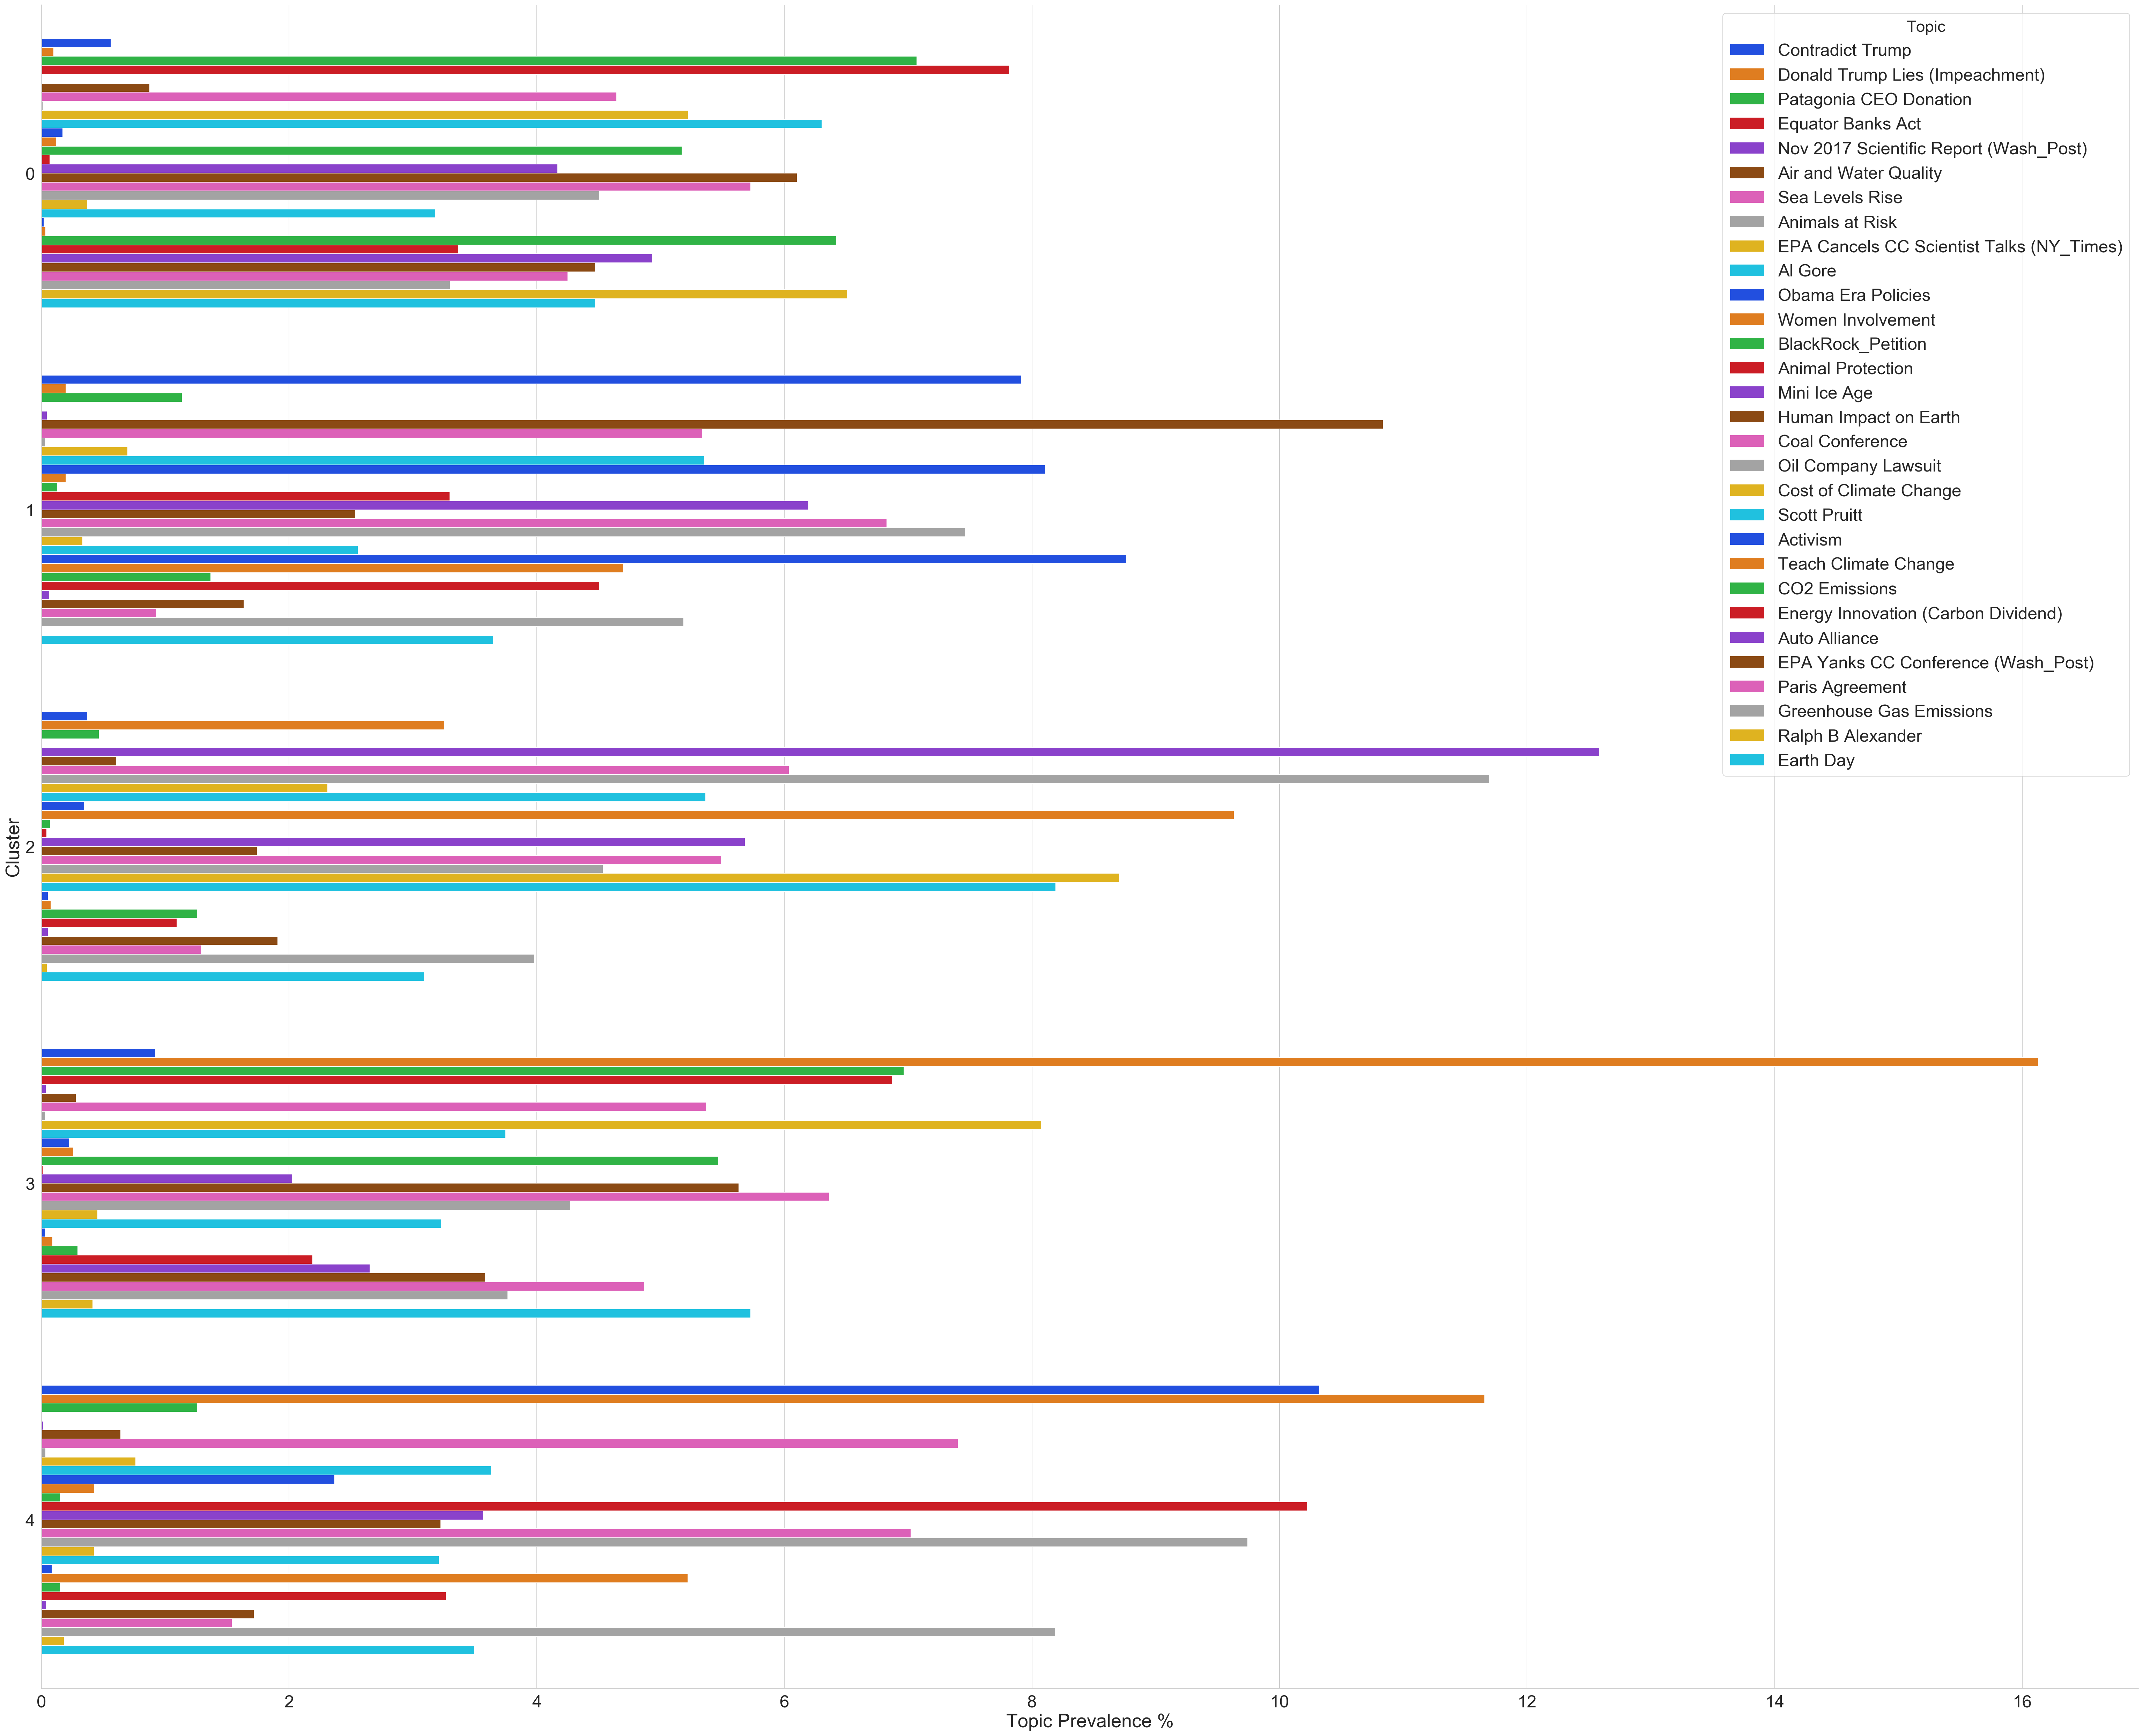

In [572]:
# Plot Topic prevalence within each cluster

with sns.plotting_context("notebook", font_scale=2.25):
    topic_barplot = sns.catplot(x="Topic Prevalence %", y="Cluster", hue="Topic", data=cluster_topic_dist_df,
                                legend_out=False, orient="h", kind="bar", palette="bright")
    # topic_barplot.fig.suptitle("Topic Distribution by Cluster")
    topic_barplot.fig.set_figwidth(60)
    topic_barplot.fig.set_figheight(50)

## Cluster Summary

- **Cluster 0**
    - Close to average ratio of deniers to believers
    - All regions except Northeast, slightly more South than average
    - Neutral sentiment
    - Dominant Topics (6-8%)
        - Equator Banks Act (7.8%)
        - Patagonia CEO Donation (7.1%)
        - Ralph B Alexander (Author who says climate change is false) (6.5%)
        - CO2 Emissions (6.4%)
        - Al Gore (6.3%)
        - Human Impact on Earth (6.1%)
    - Weak Topics (< 0.05%)
        - Teach Climate Change
        - Activism
        - Animals at Risk	
        - Scientific Report (Wash_Post)
- **Cluster 1**
    - Close to average ratio of deniers to believers
    - All regions except Northeast, slightly more West than average
    - Positive sentiment
    - Dominant Topics (6-11%)
        - Air and Water Quality (10.8%)
        - Activism (8.8%)
        - Obama Era Policies (8.1%)
        - Contradict Trump (7.9%)
        - Oil Company Lawsuit (7.5%)
        - Coal Conference (6.8%)
        - Mini Ice Age (6.2%)
    - Weak Topics (< 0.05%)
        - Scientific Report (Wash_Post)
        - Animals at Risk
        - Equator Banks Act	
        - Ralph B Alexander
- **Cluster 2**
    - Higher than average ratio of deniers to believers
    - All regions
    - Negative sentiment
    - Dominant Topics (8-13%) 
        - Scientific Report (Wash_Post) (12.6%)
        - Animals at Risk	(11.7%)
        - Women Involvement (9.6%)
        - Cost of Climate Change (8.7%)
        - Scott Pruitt (8.2%)
    - Weak Topics (~< 0.05%)
        - Auto Alliance
        - Activism
        - Ralph B Alexander	
        - Animal Protection	
        - Equator Banks Act	       
- **Cluster 3**
    - Lower than average ratio of deniers to believers
    - Northeast only
    - Neutral sentiment
    - Dominant Topics (6-16%)
        - Donald Trump Lies (Impeachment) (16.1%)
        - EPA Cancels CC Scientist Talks (NY_Times) (8.1%)
        - Patagonia CEO Donation (7.0%)
        - Equator Banks Act (6.9%)
        - Coal Conference (6.4%)
    - Weak Topics (< 0.05%)
        - Nov 2017 Scientific Report (Wash_Post)
        - Animals at Risk
        - Activism
        - Animal Protection
- **Cluster 4**
    - Lower than average ratio of deniers to believers
    - Northeast only
    - Positive sentiment
    - Dominant Topics (8-12%)
        - Donald Trump Lies (Impeachment) (11.7%)
        - Contradict Trump (10.3%)
        - Animal Protection (10.2%)
        - Oil Company Lawsuit (9.7%)
        - Greenhouse Gas Emissions (8.2%)
    - Weak Topics (< 0.05%)
        - Auto Alliance	
        - Animals at Risk	
        - Nov 2017 Scientific Report (Wash_Post)
        - Equator Banks Act

---

In [554]:
# cluster_dist_dict = defaultdict(list)

# for column in cluster_topic_df.columns:
#     for cluster in range(5):
#         cluster_dist_dict[str(cluster)]    \
#         .append(round(100*cluster_topic_df[column][cluster]/
#                       sum(cluster_topic_df[column].values),1))

In [555]:
# topic_cluster_df = pd.DataFrame(data = cluster_dist_dict, index = cluster_topic_df.columns)

In [556]:
# topic_cluster_df = topic_cluster_df.stack().reset_index()

In [557]:
# topic_cluster_df.columns = ['Topic', 'Cluster', '% of Topic']

In [558]:
# topic_barplot = sns.catplot(x="% of Topic", y="Topic", hue="Cluster", data=topic_cluster_df,
#                             legend_out=False, orient="h", kind="bar", palette="bright")
# # topic_barplot.fig.suptitle("Cluster Distribution by Topic")
# topic_barplot.fig.set_figwidth(60)
# topic_barplot.fig.set_figheight(50)

---

# Cluster Plot Assuming 3 Principal Components

- Strictly for visualization purposes

In [222]:
from mpl_toolkits.mplot3d import Axes3D

In [270]:
pca3, pca3_features = pca_function(cluster_scaled, 3, 42)

In [271]:
# Compute the clusters
km5 = KMeans(n_clusters=5, random_state=42, n_init=10)
clusters = km5.fit_predict(pca3_features)

In [272]:
def display_cluster(X,km=[],num_clusters=0):
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    color = 'brgcmyk'
    alpha = 0.5
    s = 20
    
    if num_clusters == 0:
        plt.scatter(X[:,0],X[:,1], c = color[0],alpha = alpha,s = s)
    else:
        try:
            for i in range(num_clusters):
                ax.scatter(X[km.labels_==i,0],X[km.labels_==i,1], X[km.labels_==i,2], c = color[i],alpha = alpha,s=s)
                ax.scatter(km.cluster_centers_[i][0],km.cluster_centers_[i][1], km.cluster_centers_[i][2], c = color[i], marker = 'x', s = 100)
        except:
            pass

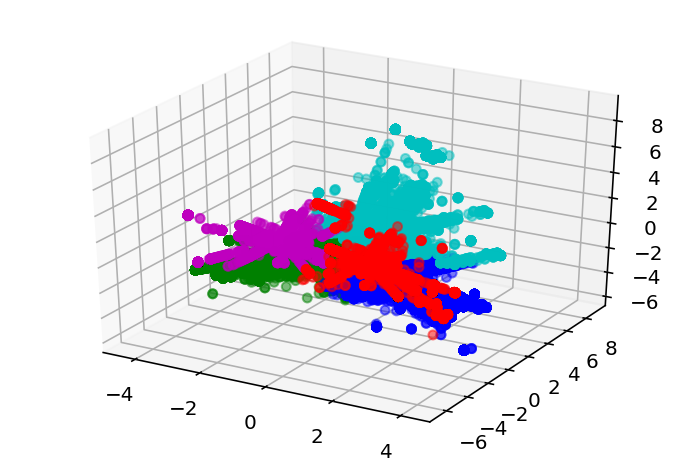

In [273]:
display_cluster(pca3_features, km5, 5)

## t_SNE

In [18]:
# from sklearn.manifold import TSNE

In [ ]:
# # Project the data: this step will take several seconds
# tsne = TSNE(n_components=3, init='random', random_state=42)
# cluster_tsne = tsne.fit_transform(pca_features)

In [ ]:
# # Compute the clusters
# kmeans = KMeans(n_clusters=7, random_state=42, n_init=10)
# clusters = kmeans.fit_predict(cluster_tsne)